In [15]:
import numpy as np
from matplotlib import pyplot as plt
from numba import jit
import time
import scipy.stats as stats
import honey_shrink as covest
import putils
from itertools import chain
from welford import Welford
import math

## Define benchmark returns

In [16]:
# =========================
# ===== Daily Returns =====
# =========================
# Some 4 OMX stocks....
mcorr = np.array(
    [
        [1.00, 0.26, 0.41, 0.57],
        [0.26, 1.00, 0.19, 0.33],
        [0.41, 0.19, 1.00, 0.52],
        [0.57, 0.33, 0.52, 1.00]
    ])
vol = np.array([0.01531293, 0.01802784, 0.02480944, 0.01251876])
p_dim = mcorr.shape[0]

mcov = np.diag(vol) @ mcorr @ np.diag(vol)
obs_gen = stats.multivariate_normal(cov=mcov)


## Calculate measures based on benchmark return distribution

In [17]:
# ====================================
# ==== Covariance Frobenius Norm =====
# ====================================
norm_exact = np.linalg.norm(mcov, 'fro')

# ====================================
# ===== Portfolio Variance Inits =====
# ====================================
# Used for estimating portfolio variance.
p_weights = np.array([1, 1, 1, 1])
p_var_exact = p_weights @ mcov @ p_weights

# ====================================
# ===== Portfolio Hedging Inits ======
# ====================================
# Used for estimating hedged portfolio variance, involing inverse of covariance matrix.
hedge_target = np.array([1, 0, 0, 0])
hdg_weights = putils.hedge_ratio(hedge_target, mcov)
p_hdgvar_exact = putils.portfolio_var(hedge_target + hdg_weights, mcov)

## Simulate returns and estimate measures with using different sample size

In [18]:
# ====================================
# =========== Monte Carlo ============
# ====================================
def init_grid(max_sample_size):
    # Grid of number of samples. Don't allow nsamples == p_dim, too avoid possibly singular covariance matrices.
    ubound = int(math.log(max_sample_size)/math.log(2) - 1) # largest k such that 2^(k+1) <= max_samples_size.
    T_grid = np.array( list(chain.from_iterable([range(p_dim * 2**k, p_dim * 2**(k+1), 4**k) for k in range(ubound)]))[1::] )
    return T_grid

nsims = 2000
T_grid = init_grid(max_sample_size = 64)
mle_pvar, mle_hdgvar, mle_norm, shrink_pvar, shrink_hdgvar, shrink_norm = (Welford(len(T_grid)) for i in range(6))
assert T_grid[0] >= p_dim
for k in range(nsims):
    X = obs_gen.rvs(T_grid[-1])
    for t_idx, t in enumerate(T_grid):
        # ==== MLE (Sample cov) =====
        mcov_mle = covest.sample_cov(X[0:t,:])
        p_var, hdg_var = putils.portfolio_statistics(p_weights, hedge_target, mcov_mle)
        mle_pvar.update(p_var, t_idx)
        mle_hdgvar.update(hdg_var, t_idx)
        mle_norm.update( np.linalg.norm(mcov_mle - mcov, ord='fro') / norm_exact, t_idx)
        
        # ==== Shrinkage =====
        mcov_honey = covest.honey_shrink(X[0:t,:])
        norm_honey = np.linalg.norm(mcov_honey - mcov, ord='fro')
        p_var, hdg_var = putils.portfolio_statistics(p_weights, hedge_target, mcov_honey)
        shrink_pvar.update(p_var, t_idx)
        shrink_hdgvar.update(hdg_var, t_idx)
        shrink_norm.update( np.linalg.norm(mcov_honey - mcov, ord='fro') / norm_exact, t_idx)


## Plot estimates

### Plot helpers

In [23]:
ALPHA_CONF = 0.05
color = {'mle':'#1f77b4', 'shrink':'#ff7f0e'}
conf_label = dict((name, '{}$_{{\\alpha={:.3g}\%}}$'.format(name, 100*ALPHA_CONF)) for name in ['mle', 'shrink'])

def mean_confint(welford_obj, conf_alpha):
    mean = welford_obj.mean()
    mean_std = welford_obj.samplevariance() / welford_obj.count()
    shift = stats.norm.ppf(1.0 - conf_alpha/2.0) * mean_std # CLT -> gaussian
    return {'mean.LB':mean - shift, 'mean':mean, 'mean.UB':mean + shift}

def relerr_mean_var(welford_obj, rel_benchmark):
    ''' V[est/exact-1] '''
    return (welford_obj.samplevariance() / welford_obj.count()) / rel_benchmark**2

def relerr_mean_confint(welford_obj, rel_benchmark, conf_alpha):
    rerr = welford_obj.mean() / rel_benchmark -1
    rerr_std = relerr_mean_var(welford_obj, rel_benchmark) ** 0.5
    shift = stats.norm.ppf(1.0 - conf_alpha/2.0) * rerr_std # CLT -> gaussian
    return {'relerr.LB':rerr - shift, 'relerr.mean':rerr, 'relerr.UB':rerr + shift}

### Normalized Frobenius Norm
Present normalized Frobenius norm, which is what most shrinkage estimators are minimizing.

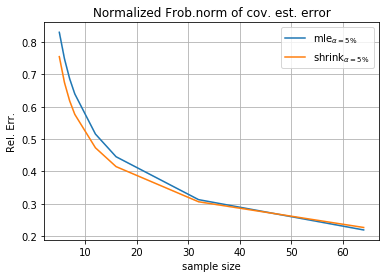

In [24]:
plt.figure()
plt.title('Normalized Frob.norm of cov. est. error')
plt.xlabel('sample size'); plt.ylabel('Rel. Err.')
mle = mean_confint(mle_norm, conf_alpha=ALPHA_CONF)
plt.plot(T_grid, mle['mean'], color=color['mle'], label=conf_label['mle'])
plt.fill_between(T_grid, mle['mean.LB'], mle['mean.UB'], color=color['mle'], alpha=0.1)

shrink = mean_confint(shrink_norm, conf_alpha=ALPHA_CONF)
plt.plot(T_grid, shrink['mean'], color=color['shrink'], label=conf_label['shrink'])
plt.fill_between(T_grid, shrink['mean.LB'], shrink['mean.UB'], color=color['shrink'], alpha=0.1)
plt.legend(); plt.grid(True)

### Portfolio Variance and MVP

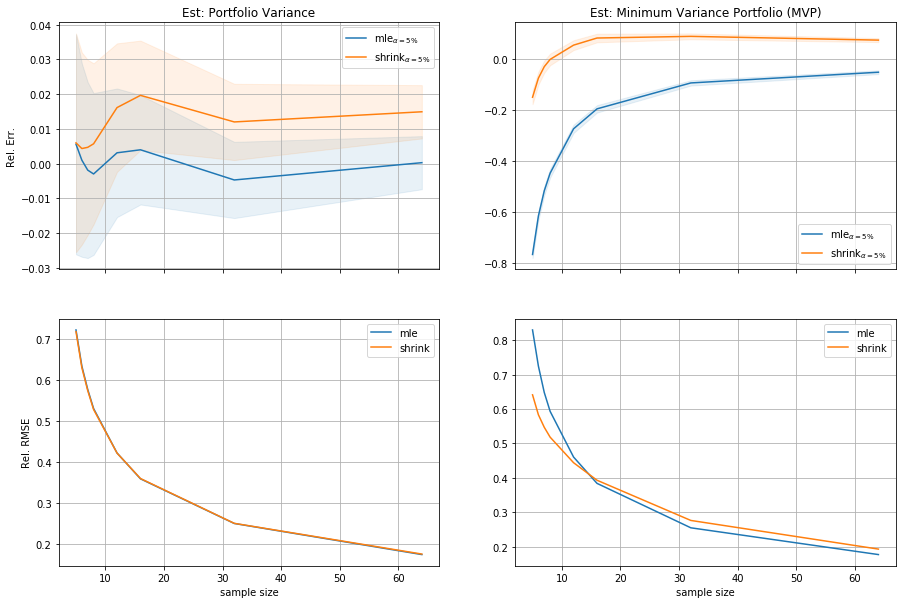

In [25]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(15,10))

# === [0,0] Portf. Var., Rel.Err. with conf. ===
axs[0, 0].set_title('Est: Portfolio Variance')
axs[0, 0].set(xlabel='', ylabel='Rel. Err.')
mle = relerr_mean_confint(mle_pvar, p_var_exact, conf_alpha=ALPHA_CONF)
axs[0, 0].plot(T_grid, mle['relerr.mean'], color=color['mle'], label=conf_label['mle'])
axs[0, 0].fill_between(T_grid, mle['relerr.LB'], mle['relerr.UB'], color=color['mle'], alpha=0.1)

shrink = relerr_mean_confint(shrink_pvar, p_var_exact, conf_alpha=ALPHA_CONF)
axs[0, 0].plot(T_grid, shrink['relerr.mean'], color=color['shrink'], label=conf_label['shrink'])
axs[0, 0].fill_between(T_grid, shrink['relerr.LB'], shrink['relerr.UB'], color=color['shrink'], alpha=0.1)

# === [1,0] Rel. RMSE ===
axs[1, 0].set_title('')
axs[1, 0].set(xlabel='sample size', ylabel='Rel. RMSE')
rerr_mle = mle_pvar.MSE(p_var_exact)**0.5 / p_var_exact
axs[1, 0].plot(T_grid, rerr_mle, color=color['mle'], label='mle')

rerr_shrink = shrink_pvar.MSE(p_var_exact)**0.5 / p_var_exact
axs[1, 0].plot(T_grid, rerr_shrink, color=color['shrink'], label='shrink')

# === [0,1] Min.Var.Port. Rel.Err. with conf. ===
axs[0, 1].set_title('Est: Minimum Variance Portfolio (MVP)')
axs[0, 1].set(xlabel='', ylabel='')
mle = relerr_mean_confint(mle_hdgvar, p_hdgvar_exact, conf_alpha=ALPHA_CONF)
axs[0, 1].plot(T_grid, mle['relerr.mean'], color=color['mle'], label=conf_label['mle'])
axs[0, 1].fill_between(T_grid, mle['relerr.LB'], mle['relerr.UB'], color=color['mle'], alpha=0.1)

shrink = relerr_mean_confint(shrink_hdgvar, p_hdgvar_exact, conf_alpha=ALPHA_CONF)
axs[0, 1].plot(T_grid, shrink['relerr.mean'], color=color['shrink'], label=conf_label['shrink'])
axs[0, 1].fill_between(T_grid, shrink['relerr.LB'], shrink['relerr.UB'], color=color['shrink'], alpha=0.1)

# == Relative Rooth Mean Squared Error (RRMSE == RMSRE) ==
axs[1, 1].set_title('')
axs[1, 1].set(xlabel='sample size', ylabel='')
rerr_mle = mle_hdgvar.MSE(p_hdgvar_exact)**0.5 / p_hdgvar_exact
axs[1, 1].plot(T_grid, rerr_mle, color=color['mle'], label='mle')
rerr_shrink = shrink_hdgvar.MSE(p_hdgvar_exact)**0.5 / p_hdgvar_exact
axs[1, 1].plot(T_grid, rerr_shrink, color=color['shrink'], label='shrink')

for ax in axs.flatten():
    ax.legend(); ax.grid(True)

plt.show()

## Comments
For the above given covariance matrix, mle performs better than shrinkage for 

NameError: name 'kk' is not defined